# News Headlines Sentiment

Use the news api to pull the latest news articles for stock and create a DataFrame of sentiment scores. 

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()


%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dragan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# input stock ticker

ticker = 'MSRT'

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/dragan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dragan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dragan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Read your api key environment variable
api_key = os.getenv("NEWS_API_KEY")

In [5]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [6]:
# Fetch the stock news articles; put in the ticker symbol of the stock you need information about
stock_headlines = newsapi.get_everything(q=(f"{ticker}"), language="en", page_size=100,sort_by="relevancy")
stock_articles = stock_headlines["articles"]
stock_articles[0]

{'source': {'id': None, 'name': 'Business Wire'},
 'author': None,
 'title': 'MassRoots Exploring Re-Launch of its Mobile Applications',
 'description': 'DENVER--(BUSINESS WIRE)---- $MSRT #MassRoots--MassRoots, Inc. ("MassRoots" or the "Company") (OTC:MSRT), a technology company focused on the regulated cannabis industry, announced today that it is exploring the re-launch of its mobile applications with an emp…',
 'url': 'https://www.businesswire.com/news/home/20210224005336/en/MassRoots-Exploring-Re-Launch-of-its-Mobile-Applications',
 'urlToImage': 'https://mms.businesswire.com/media/20210224005336/en/861062/23/4410299_MR-LOGO.jpg',
 'publishedAt': '2021-02-24T13:20:10Z',
 'content': 'DENVER--(BUSINESS WIRE)--MassRoots, Inc. ("MassRoots" or the "Company") (OTC:MSRT), a technology company focused on the regulated cannabis industry, announced today that it is exploring the re-launch… [+3373 chars]'}

In [7]:
# Create the stock sentiment scores DataFrame
stock_sentiments = []

for article in stock_articles:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        stock_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
stock_df = pd.DataFrame(stock_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
stock_df = stock_df[cols]

In [8]:
# Drop duplicates articles
stock_df.drop_duplicates(keep="first", inplace=True)
stock_df.head()

,date,text,compound,positive,negative,neutral
0,2021-02-24,"DENVER--(BUSINESS WIRE)--MassRoots, Inc. (""Mas...",0.3818,0.094,0.0,0.906
1,2021-03-08,"DENVER--(BUSINESS WIRE)--MassRoots, Inc. (""Mas...",0.4767,0.141,0.0,0.859


In [9]:
# Describe the stock sentiment
stock_df.describe()

,compound,positive,negative,neutral
count,2.000000,2.000000,2.0,2.000000
mean,0.429250,0.117500,0.0,0.882500
std,0.067104,0.033234,0.0,0.033234
min,0.381800,0.094000,0.0,0.859000
25%,0.405525,0.105750,0.0,0.870750
50%,0.429250,0.117500,0.0,0.882500
75%,0.452975,0.129250,0.0,0.894250
max,0.476700,0.141000,0.0,0.906000


---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each stock. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [10]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import regex
import re

In [11]:
stock_text_df = stock_df['text'].astype('str')
stock_text_df

0    DENVER--(BUSINESS WIRE)--MassRoots, Inc. ("Mas...
1    DENVER--(BUSINESS WIRE)--MassRoots, Inc. ("Mas...
Name: text, dtype: object

In [12]:
# Complete the tokenizer function
def tokenizer(text):

    """Tokenizes text."""

    # Create a list of the words
    words = [word_tokenize(sentence) for sentence in text]

    # Remove punctuation using regex; Remove any non-string character and replace with empty space
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words_clean = word_tokenize(re_clean)
   
   # Remove the stop words
    sw = set(stopwords.words('english'))
    first_pass = [word for word in words_clean if word not in sw]

    # Define additional stopwords
    sw_addon = {'char', 'chars' 'la', 'im','volod', 'drin', 'wa', 'ha'}
    second_pass = [word.lower() for word in words_clean if word.lower() not in sw.union(sw_addon)] 

    # Lemmatize Words into root words; convert the words to lowercase
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in words_clean]
    tokens = [word.lower() for word in lem if word.lower() not in sw.union(sw_addon)] 
  
    return tokens

In [13]:
# Tokenizing article in the first row of the "text" column
tokenizer(stock_text_df[0])

['denverbusiness',
 'wiremassroots',
 'inc',
 'massroots',
 'company',
 'otcmsrt',
 'technology',
 'company',
 'focused',
 'regulated',
 'cannabis',
 'industry',
 'announced',
 'today',
 'exploring',
 'relaunch']

In [14]:
# Create for-loop to iterate through rows in the "text" column 
stock_tokens = []
for row in stock_text_df:
    token = tokenizer(row)
    stock_tokens.append(token)

    print(stock_tokens) 

[['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused', 'regulated', 'cannabis', 'industry', 'announced', 'today', 'exploring', 'relaunch']]
[['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused', 'regulated', 'cannabis', 'industry', 'announced', 'today', 'exploring', 'relaunch'], ['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused', 'regulated', 'cannabis', 'industry', 'announced', 'today', 'launched', 'new', 'imp']]


In [15]:
# Create a new tokens column for the stock
stock_df['btc_token'] = stock_tokens
stock_df.head()

,date,text,compound,positive,negative,neutral,btc_token
0,2021-02-24,"DENVER--(BUSINESS WIRE)--MassRoots, Inc. (""Mas...",0.3818,0.094,0.0,0.906,"[denverbusiness, wiremassroots, inc, massroots..."
1,2021-03-08,"DENVER--(BUSINESS WIRE)--MassRoots, Inc. (""Mas...",0.4767,0.141,0.0,0.859,"[denverbusiness, wiremassroots, inc, massroots..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each stock. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each stock. 

In [16]:
from collections import Counter
from nltk import ngrams

In [17]:
# Create one list of tokens from list of tokens in each row
stock_processed = []
for row in stock_df['btc_token']:
    for item in row:
        stock_processed.append(item)
        print(stock_processed)

['denverbusiness']
['denverbusiness', 'wiremassroots']
['denverbusiness', 'wiremassroots', 'inc']
['denverbusiness', 'wiremassroots', 'inc', 'massroots']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused', 'regulated']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused', 'regulated', 'cannabis']
['denverbusiness', 'wiremassroots', 'inc', 'massroots', 'company', 'otcmsrt', 'technology', 'company', 'focused', 'regulated',

In [18]:
# Generate the Bitcoin N-grams where N=2
stock_bigram = Counter(ngrams(stock_processed, n=2))
print(dict(stock_bigram))


{('denverbusiness', 'wiremassroots'): 2, ('wiremassroots', 'inc'): 2, ('inc', 'massroots'): 2, ('massroots', 'company'): 2, ('company', 'otcmsrt'): 2, ('otcmsrt', 'technology'): 2, ('technology', 'company'): 2, ('company', 'focused'): 2, ('focused', 'regulated'): 2, ('regulated', 'cannabis'): 2, ('cannabis', 'industry'): 2, ('industry', 'announced'): 2, ('announced', 'today'): 2, ('today', 'exploring'): 1, ('exploring', 'relaunch'): 1, ('relaunch', 'denverbusiness'): 1, ('today', 'launched'): 1, ('launched', 'new'): 1, ('new', 'imp'): 1}


In [19]:
# Print 20 most common stock bigrams
print(dict(stock_bigram.most_common(20)))

{('denverbusiness', 'wiremassroots'): 2, ('wiremassroots', 'inc'): 2, ('inc', 'massroots'): 2, ('massroots', 'company'): 2, ('company', 'otcmsrt'): 2, ('otcmsrt', 'technology'): 2, ('technology', 'company'): 2, ('company', 'focused'): 2, ('focused', 'regulated'): 2, ('regulated', 'cannabis'): 2, ('cannabis', 'industry'): 2, ('industry', 'announced'): 2, ('announced', 'today'): 2, ('today', 'exploring'): 1, ('exploring', 'relaunch'): 1, ('relaunch', 'denverbusiness'): 1, ('today', 'launched'): 1, ('launched', 'new'): 1, ('new', 'imp'): 1}


In [20]:
# Use the token_count function to generate the top 10 words from each stock
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [21]:
# Get the top 10 words for the stock
stock_top_ten = token_count(stock_processed)
stock_top_ten

[('company', 4),
 ('denverbusiness', 2),
 ('wiremassroots', 2),
 ('inc', 2),
 ('massroots', 2),
 ('otcmsrt', 2),
 ('technology', 2),
 ('focused', 2),
 ('regulated', 2),
 ('cannabis', 2)]

# Word Clouds

In this section, you will generate word clouds for the stock to summarize the news for each stock

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Word Cloud')

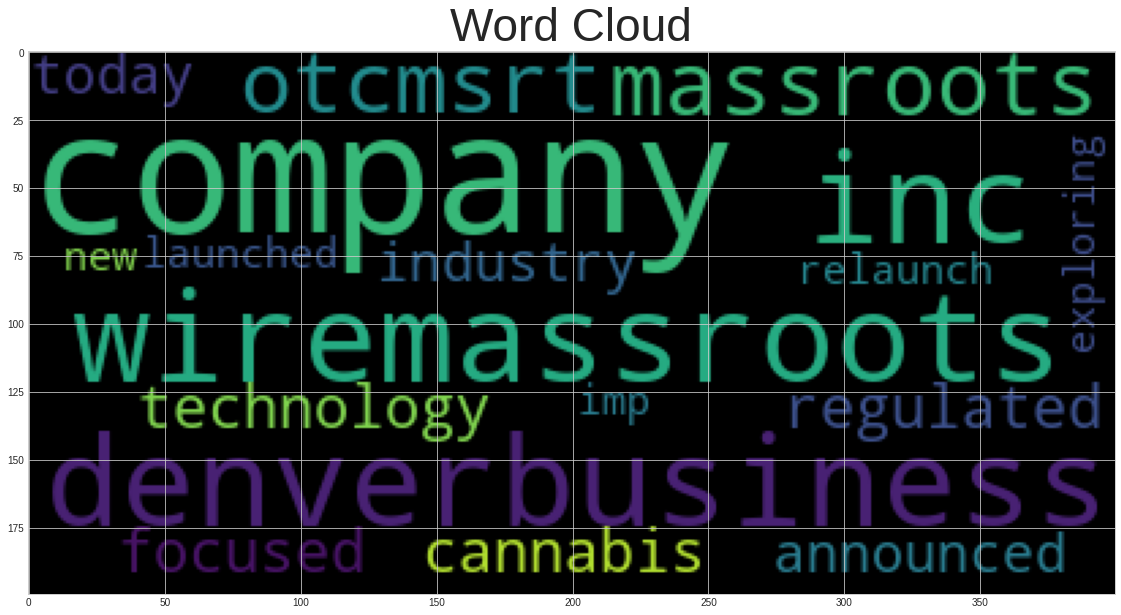

In [23]:
# Generate the stock word cloud
wc = WordCloud().generate(' '.join(stock_processed))
plt.imshow(wc)

# Add title to a Word Cloud 
plt.title("Word Cloud", fontdict={"fontsize":46})

# Named Entity Recognition

In this section, you will build a named entity recognition model for stock and visualize the tags using SpaCy.

In [24]:
import spacy
from spacy import displacy

In [25]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Stock NER

In [26]:
# Concatenate all of the stock text together
stock_joined = " ".join(stock_processed)

In [27]:
# Run the NER processor on all of the text
doc_stock = nlp(stock_joined)

# Add a title to the document
doc_stock.user_data["title"] = "Stock NER"

In [28]:
# Render the visualization
displacy.render(doc_stock, style='ent')

In [29]:
# List all Entities
print([ent.text for ent in doc_stock.ents])

['today', 'today']


---